<div class="alert alert-block alert-info"><b> 	Load the Libraries. </b> </div>

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
from datetime import datetime
import dateutil.parser
import scipy.stats as scs
from scipy import stats
from sklearn.cluster import KMeans 
from sklearn import cluster 
from sklearn import metrics 
import matplotlib.pyplot as plt
import sqlite3
import warnings 
warnings.filterwarnings("ignore") 

<div class="alert alert-block alert-info"><b> 	Load and Clean the data. </b> </div>

In [135]:
df = pd.read_csv('.\data.tsv', sep='\t')

In [136]:
df.dtypes

date        object
user_id     object
activity    object
dtype: object

#### Converting the date from Object to datetime

In [137]:
df['date'] = df['date'].astype('datetime64[ns]')
df['date'] = pd.to_datetime(df['date'],format ='%y%m%d')
df['date'].head()

0   2017-01-01
1   2017-01-01
2   2017-01-01
3   2017-01-01
4   2017-01-01
Name: date, dtype: datetime64[ns]

<div class="alert alert-block alert-info"><b>Part1 - Create the retention plot </b> <b></b> <b></b> <br/>
<b>

    
    1. Load the data
    2. Find the no of data points(Rows) and Features(columns)
    3. Feature (Column) names
    4. Daily Cohort 
    5. Customer Retention
    6. Retention Plot
  </b> <b> Part 2b) - Is there a part of the retention curve that deserves more attention?  </b> <b></b> <b></b> 
  <br/>
 </b> <b> Part 2a) - Correlation between the type of activity and retention?  </b> <b></b> <b></b> <br/>
 <b>
 
    7. RFM  (Recency, frequency, and Monetary) Segmentation
    8. Analyzing Skewness 
    9. Log transformation
    10. Elbow Method. Finding clusters
    11. Standardization of the data
    12. Creating Cluster
    13. Analyzing the Clusters 
    14. Correlation between the type of activity and retention
    
    
 
  </b> <b> Part 2c) - What would you recommend as a follow up experiment or how would you dig deeper?  </b> <b></b> <b></b>     


    
</div>

In [138]:
class Retention_Rate:
    
    def __init__(self,data):
        # Load the data
        self.data = data
        self.No_of_Data_points()
    def No_of_Data_points(self):
        x= list(self.data.shape)
        return (x)
    def column_names(self):
        x= list(self.data.columns)
        return (x)
    def daily_cohort(self):
        grouping = self.data.groupby('user_id')['date']
        # Assign the first date that customer logged in
        self.data['CohortDate'] = grouping.transform('min')
        # With this, acquistion month is assigned to each customer
        #self.data.tail()
        #Calculate the difference between the date and the cohort date
        # This will give the no of days between any transaction and first transaction for each customer
        self.data['CohortIndex'] = ((pd.to_datetime (self.data['date'])- pd.to_datetime(self.data['CohortDate']))/pd.offsets.Day(1)) +1
        self.data['CohortDate'] = self.data['CohortDate'].dt.strftime('%Y-%m-%d')
        #self.data.info()
        #Count daily active users from each cohort
        grouping = self.data.groupby(['CohortDate','CohortIndex' ])
        cohort_data = grouping['user_id'].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot(index = 'CohortDate', columns = 'CohortIndex', values = 'user_id' )
        return(cohort_counts)
    def Customer_retention_rate_calc(self):
        # Customer retention from the Cohort count table
        # 1. How many customers originally in each cohort
        # 2. How many of them were active in following days
        cohort_counts = self.daily_cohort()
        cohort_sizes = cohort_counts.iloc[:,0]
        # Divide all values in the cohort_counts table by cohort_sizes
        retention = cohort_counts.divide(cohort_sizes, axis = 0)
        #retention.round(3) * 100
        return retention, cohort_sizes
    def retention_plot(self):
        retention,cohort_sizes = self.Customer_retention_rate_calc()
        retention_matrix = retention[[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0]]
        # plot the retention matrix
        with sns.axes_style("white"):
            fig, ax = plt.subplots(1, 2, figsize=(15, 15), sharey=True, gridspec_kw={'width_ratios': [1, 15]})

            # retention matrix
            sns.heatmap(retention_matrix, 
                        mask=retention_matrix.isnull(), 
                        annot=True, 
                        fmt='.0%', 
                        cmap='RdYlGn', 
                        ax=ax[1])
            ax[1].set_title('Daily Cohorts: User Retention', fontsize=16)
            ax[1].set(xlabel='# of periods',
                      ylabel='')

            # cohort size
            cohort_size_df = pd.DataFrame(cohort_sizes).rename(columns={0: 'cohort_size'})
            white_cmap = mcolors.ListedColormap(['white'])
            sns.heatmap(cohort_size_df, 
                        annot=True, 
                        cbar=False, 
                        fmt='g', 
                        cmap=white_cmap, 
                        ax=ax[0])

            fig.tight_layout()
    def rfm_segmentation(self):
        #1. Recency - How recent the customer last activity
        #2. Frequency - No of activities that customers has done in two months
        #3. Monetary value - How much the customer has spent in two months. (Not available in the data)
        # Assuming we are doing the analysis at the end of March 2017
        End_QTR = datetime(2017, 3, 30)
        rfm = df.groupby('user_id').agg({'date': lambda date: (End_QTR - date.max()).days,
                            'activity': lambda num: len(num)})
        rfm.columns = ['recency','frequency']
        # Computing Quantile of RFM values
        #Customers with the lowest recency, highest frequency are considered as top customers. 
        return rfm
    def Analyzing_Skewness(self):
        # Check the distribution of recency and frequency
        rfm = self.rfm_segmentation()
        sns.distplot(rfm['recency'])
        plt.show()
        print("Recency is right skewed distribution")
        sns.distplot(rfm['frequency'])
        plt.show()
        print("frequency is right skewed distribution")
    def log_transformation(self):
        rfm = self.rfm_segmentation()
        recency_log = np.log(rfm['recency'])
        rfm['recency_log'] = recency_log
        sns.distplot(rfm['recency_log'])
        plt.show()
        
        frequency_log = np.log(rfm['frequency'])
        rfm['frequency_log'] = frequency_log
        sns.distplot(rfm['frequency_log'])
        plt.show()
        return rfm
    def Standardize_Data(self):
        rfm = self.rfm_segmentation()
        recency_log = np.log(rfm['recency'])
        rfm['recency_log'] = recency_log
        frequency_log = np.log(rfm['frequency'])
        rfm['frequency_log'] = frequency_log
        cols = ['recency_log','frequency_log']
        zcols = [] 
        for col in cols: 
            rfm['z_' + col] = (rfm[col] - rfm[col].mean())/rfm[col].std() 
            zcols.append('z_' + col)
        return rfm
    def Finding_Cluster(self):
        # find the number of clusters- Elbow method
        rfm = self.Standardize_Data()
        data_normalized = rfm[['z_recency_log','z_frequency_log']]
        sse ={}
        for k in range(1,11):
            kmeans = KMeans(n_clusters =k, random_state =1)
            kmeans.fit(data_normalized)
            sse[k]= kmeans.inertia_ #sum of squared distance to closest cluster center
        # Plot SSE for each *k*
        plt.title('The Elbow Method')
        plt.xlabel('k'); plt.ylabel('SSE')
        sns.pointplot(x=list(sse.keys()),y=list(sse.values()) )
        plt.show()
    
    def Creating_Cluster (self):
        rfm = self.Standardize_Data()
        data_normalized = rfm[['z_recency_log','z_frequency_log']]
        model = cluster.KMeans(n_clusters=3, random_state=1) 
        model.fit_predict(data_normalized) 
        cluster_assignments = model.labels_ 
        centers = model.cluster_centers_
        rfm['Cluster']= cluster_assignments
        return rfm

        
        

        
        
    
            

<div class="alert alert-block alert-info"><b> 	Create the instance of the class </b> </div>

In [62]:
y = Retention_Rate(df)

In [13]:
Daily_Cohort = y.daily_cohort()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060146 entries, 0 to 1060145
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   date         1060146 non-null  datetime64[ns]
 1   user_id      1060146 non-null  object        
 2   activity     1060146 non-null  object        
 3   CohortDate   1060146 non-null  object        
 4   CohortIndex  1060146 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 40.4+ MB


<div class="alert alert-block alert-info"><b> 	Retention rate calculation </b> </div>

In [139]:
retention,_ = y.Customer_retention_rate_calc()

In [140]:
retention.head()

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0
CohortDate,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,0.264636,0.195807,0.189742,0.159415,0.161524,0.245517,0.234177,0.163107,0.157305,...,0.161788,0.138845,0.114847,0.111419,0.104826,0.100343,0.136603,0.171941,0.121176,0.087421
2017-01-02,1.0,0.206399,0.180206,0.149204,0.123011,0.179377,0.182195,0.143899,0.130637,0.125663,...,0.113893,0.093336,0.088362,0.085378,0.065816,0.099469,0.134284,0.097149,0.070292,NaN
2017-01-03,1.0,0.190476,0.155436,0.129829,0.153414,0.152066,0.132749,0.131402,0.116577,0.117925,...,0.083783,0.082435,0.080638,0.063118,0.084232,0.113657,0.091644,0.062668,NaN,NaN
2017-01-04,1.0,0.186505,0.128205,0.158435,0.144130,0.124157,0.121457,0.119298,0.115789,0.093657,...,0.074764,0.067476,0.061269,0.075034,0.111471,0.078812,0.059379,NaN,NaN,NaN
2017-01-05,1.0,0.151575,0.156219,0.139635,0.117081,0.121725,0.101824,0.101824,0.092537,0.118076,...,0.063682,0.056716,0.066998,0.092206,0.069983,0.051410,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info"><b> 	Retention rate plot </b> </div>

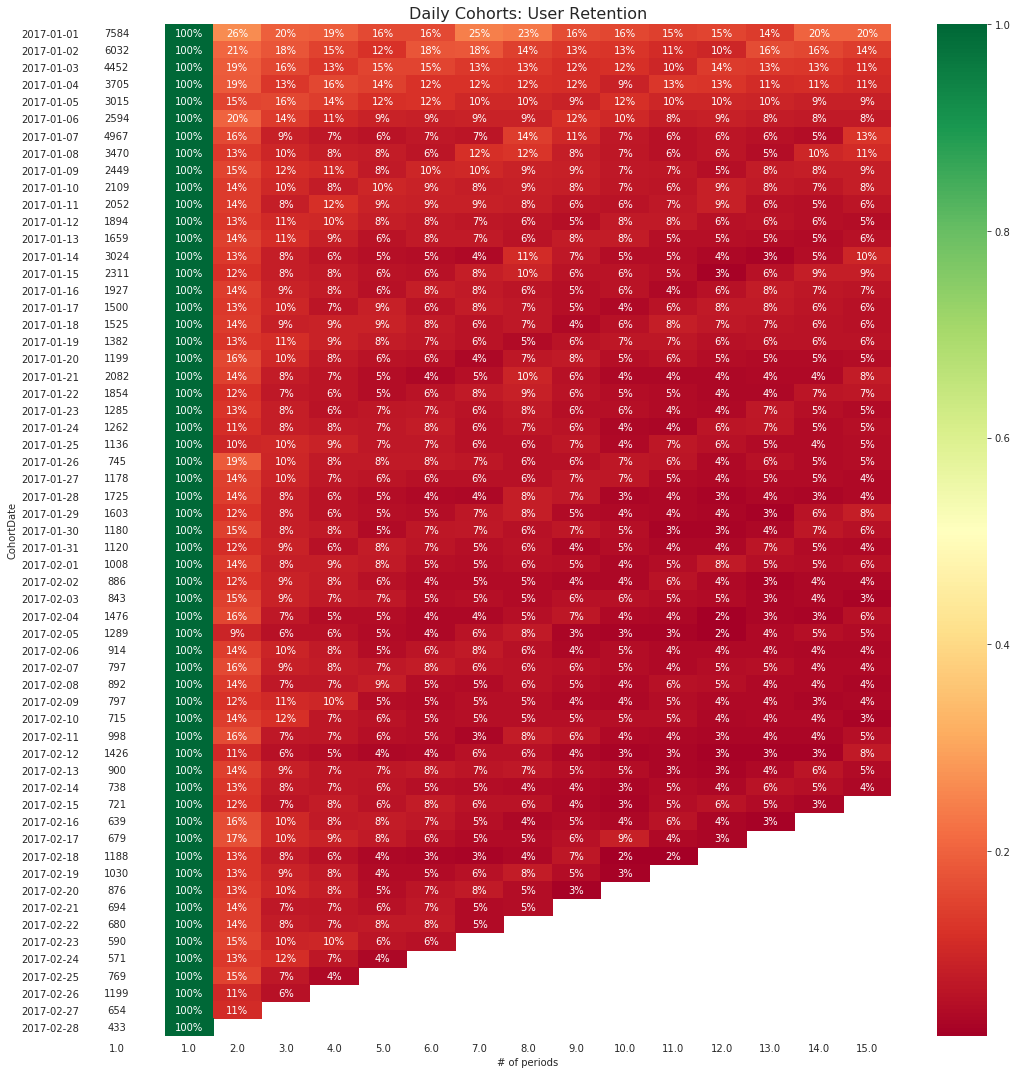

In [141]:
y.retention_plot()

<div class="alert alert-block alert-info"><b> 	Part 2b) - Is there a part of the retention curve that deserves more attention? </b> </div>

<div class="alert alert-block alert-success"><b>Summary:</b> 
<br>
1. In the image, we can see that there is a sharp drop off on the 2nd day, on average 80% of customers have no activity on 2nd day.
<br>

    
    a) The first cohort '2017-01-01' seems to be an exception and performs well as compared to the other ones
    b) Week after the first activity, there is a 25% retention. This might be a cohort of dedicated customers
   


    

    
</div>

<div class="alert alert-block alert-info"><b> 	RFM segmentation </b> </div>

In [26]:
rfm_dataset = y.rfm_segmentation()

In [27]:
rfm_dataset.head()

,recency,frequency
user_id,,
00016fd57052a1a0e238ab0a46725884,32,4
000188621e54163f77d2cfa5c90a5247,35,7
000307cf1416a44620ff6438eb8cd654,39,16
00033c9c4573d62ae711ae53eda06133,30,30
00042917bd1df5d0644b84bdba7df5bd,68,13


<div class="alert alert-block alert-info"><b> 	Analyzing Skewness </b> </div>

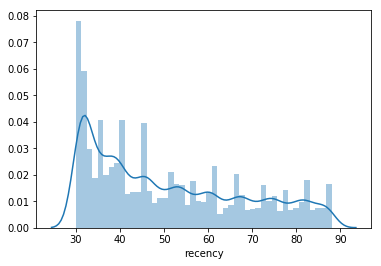

Recency is right skewed distribution


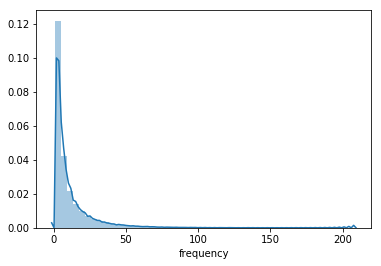

frequency is right skewed distribution


In [32]:
y.Analyzing_Skewness()

<div class="alert alert-block alert-success"><b>Summary:</b> 
<br>
1. Both Recency and Frequency are right skewed
<br>

    
    a) Frequency has even worst distribution. Most of the values lies between 0-25
    b) Next step - Log transformation of both variables
   


    

    
</div>

<div class="alert alert-block alert-info"><b> 	Log Transformatoion </b> </div>

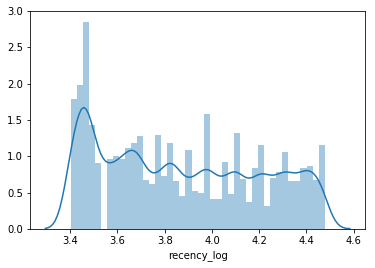

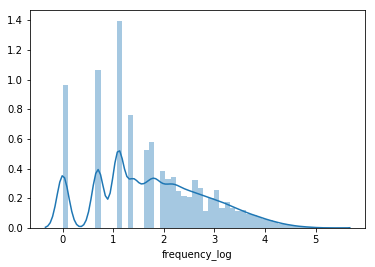

In [142]:
rfm = y.log_transformation()

<div class="alert alert-block alert-success"><b>Summary:</b> 
<br>
1. Both Recency and Frequency looks more normal. Will use log columns for K-Means clustering

</div>

In [143]:
rfm[['recency_log','frequency_log']].describe()

,recency_log,frequency_log
count,98422.000000,98422.000000
mean,3.870264,1.770879
std,0.333343,1.081832
min,3.401197,0.000000
25%,3.555348,1.098612
50%,3.828641,1.609438
75%,4.158883,2.564949
max,4.477337,5.332719


Mean and standard deviation of recency and frequency is very different. We need to normalize the data
Standardize the data in each column by looping through each column, and store the results in new columns named with a z_ prefix. 

<div class="alert alert-block alert-info"><b> 	Standardize the data </b> </div>

In [50]:
rfm = y.Standardize_Data()

In [51]:
rfm[['z_recency_log','z_frequency_log']].describe()

,z_recency_log,z_frequency_log
count,9.842200e+04,9.842200e+04
mean,2.888894e-12,-4.827571e-13
std,1.000000e+00,1.000000e+00
min,-1.407159e+00,-1.636926e+00
25%,-9.447207e-01,-6.214148e-01
50%,-1.248649e-01,-1.492291e-01
75%,8.658309e-01,7.340055e-01
max,1.821164e+00,3.292415e+00


After standardization, Mean ~ 0 and standard deviation ~1 of recency and frequency

<div class="alert alert-block alert-info"><b> 	FInding Clusters- Elbow Method </b> </div>

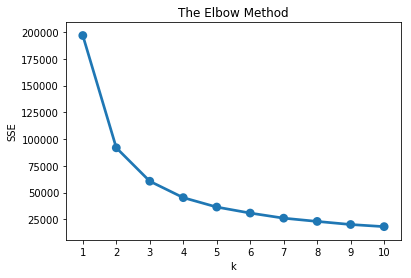

In [145]:
y.Finding_Cluster()

<div class="alert alert-block alert-info"><b> 	Creating Clusters in the dataset </b> </div>

Sharp drop of SSE at clusters 2 and 3, and then it tapers down. Three clusters make sense and will use for clustering

In [146]:
rfm = y.Creating_Cluster()

In [147]:
# Calculate average RFM values for each cluster
rfm.groupby('Cluster').agg({'recency': 'mean', 'frequency': 'mean'}).round(1)

,recency,frequency
Cluster,,
0,69.7,4.0
1,40.4,4.2
2,37.4,24.8


<div class="alert alert-block alert-info"><b> 	Labeling the cluster </b> </div>

In [148]:
def Cluster_label(df):
    if df['Cluster'] == 0:
        return 'Bronze'
    if df['Cluster'] == 1:
        return 'Silver'
    else:
        return 'Gold'

In [149]:
rfm['General_Segment'] = rfm.apply(Cluster_label, axis =1 )

In [150]:
rfm.head()

,recency,frequency,recency_log,frequency_log,z_recency_log,z_frequency_log,Cluster,General_Segment
user_id,,,,,,,,
00016fd57052a1a0e238ab0a46725884,32,4,3.465736,1.386294,-1.213549,-0.355494,1,Silver
000188621e54163f77d2cfa5c90a5247,35,7,3.555348,1.945910,-0.944721,0.161792,1,Silver
000307cf1416a44620ff6438eb8cd654,39,16,3.663562,2.772589,-0.620090,0.925939,2,Gold
00033c9c4573d62ae711ae53eda06133,30,30,3.401197,3.401197,-1.407159,1.506998,2,Gold
00042917bd1df5d0644b84bdba7df5bd,68,13,4.219508,2.564949,1.047699,0.734006,0,Bronze


<div class="alert alert-block alert-info"><b> Part 2a)	Correlation between Activity and Retention </b> </div>

In [87]:
rfm = rfm.reset_index()

In [88]:
rfm.columns

Index(['user_id', 'recency', 'frequency', 'recency_log', 'frequency_log',
       'z_recency_log', 'z_frequency_log', 'Cluster', 'General_Segment'],
      dtype='object')

In [89]:
df_Segment = pd.merge(df,rfm[['user_id', 'General_Segment']], on = ['user_id'] , how = 'inner')


In [93]:
df_Segment['count']=1

In [95]:
df_Segment.head()

,date,user_id,activity,CohortDate,CohortIndex,General_Segment,count
0,2017-01-01,77eb88a816585b60ecab5f9e9611bead,recipe,2017-01-01,1.0,Gold,1
1,2017-01-20,77eb88a816585b60ecab5f9e9611bead,search,2017-01-01,20.0,Gold,1
2,2017-01-05,77eb88a816585b60ecab5f9e9611bead,recipe,2017-01-01,5.0,Gold,1
3,2017-01-05,77eb88a816585b60ecab5f9e9611bead,search,2017-01-01,5.0,Gold,1
4,2017-01-20,77eb88a816585b60ecab5f9e9611bead,home_feed,2017-01-01,20.0,Gold,1


In [99]:
conn = sqlite3.connect("Yummly.db")
df_Segment.to_sql("Yummly", conn, if_exists="replace")
cur = conn.cursor()

In [101]:
df_Segment_Agg = pd.read_sql_query("select General_Segment ,activity, Sum(count) as Number_of_Activities from Yummly group by General_Segment ,activity order by 3 desc;", conn) 

In [124]:
df_Segment_Agg = pd.read_sql_query("select A.General_Segment , A.activity, cast(A.Number_of_Activities as float) / cast(B.Number_of_Activities AS float)  as retention_rate from (select General_Segment ,activity, Sum(count) as Number_of_Activities from Yummly group by General_Segment ,activity) as A inner join (select General_Segment, Sum(count) as Number_of_Activities from Yummly group by General_Segment) as B on A.General_Segment = B.General_Segment  ;", conn) 

In [125]:
df_Segment_Agg

,General_Segment,activity,retention_rate
0,Bronze,collection,0.035182
1,Bronze,home_feed,0.388518
2,Bronze,recipe,0.276063
3,Bronze,search,0.241881
4,Bronze,shopping_list,0.058355
5,Gold,collection,0.060977
6,Gold,home_feed,0.355012
7,Gold,recipe,0.301429
8,Gold,search,0.241364
9,Gold,shopping_list,0.041218


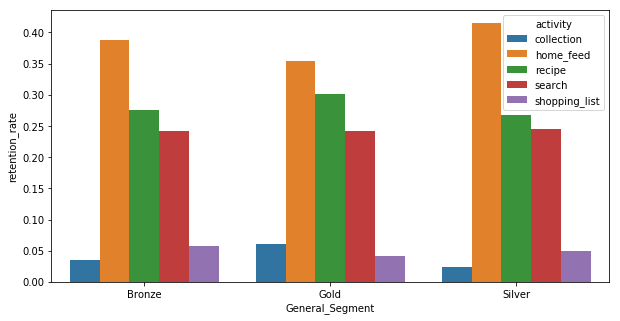

In [133]:
#Let's plot activity count by segment
plt.figure(figsize=(10,5))
sns.barplot(x="General_Segment", hue="activity", y="retention_rate", data=df_Segment_Agg)
plt.show()

* Home Feed and recipe is where all the three segments have relative high number of activities
* Collections and shopping list is where all three segments have low activities
* Low engagement in collections is worrisome need to be investigated.

<div class="alert alert-block alert-info"><b> Part 2c) Future recommendations and Project </b> </div>

<div class="alert alert-block alert-success"><b>Summary:</b> 
<br>

<br>
  
    a) Bronze-  low frequency and high recency. These are the customers most likely churned. Deep  dive the data.  Look at the Bug report. Funnel analysis where customers are dropping.
    
    b) Silver- Medium frequency and avg recency. Marketing opportunities. Run ad campaigns and promotions to entice customers in the Home feed and recipe section.
    
    c) Gold- high frequency and low recency. Product opportunities.Home feed and recipe  where the customoters are engaging and spending time. New feature to monetize in the shopping list. Also check, correlation and causation . A/B testing to find out it's not correlation.
   

  

    
</div>